# Delta Hedging 

Delta hedging is the process of offsetting price flucuations in an options contract by trading in the underlying. In this case, you would buy or sell shares of the underlying stock to offset the price changes in a particular options price.

In this notebook we will investigate the effects of delta hedging a European call option using real data from Apple stocks. We will use the Black Scholes model to price the option and the delta of the option. We will then use the delta to calculate the number of shares of Apple stock we need to buy or sell to offset the price changes in the option. We will then calculate the profit and loss of the option and the hedged position.

Here we will use dataset pulled down by Yahoo finance for the date of 20/07/2023. We will use the closing price of the stock for the day as the spot price for the option.

In [307]:
import numpy as np
import pandas as pd
import datetime as dt
from _utils import *
from _fitting import *

import matplotlib.pyplot as plt
import plotly.graph_objects as go

# set backend of matplotlib to seaborn
plt.style.use('seaborn')



/var/folders/k6/79gt8yds1l3gsjyykhx8fr4r0000gn/T/ipykernel_11319/3757379147.py:11: MatplotlibDeprecationWarning: The seaborn styles shipped by Matplotlib are deprecated since 3.6, as they no longer correspond to the styles shipped by seaborn. However, they will remain available as 'seaborn-v0_8-<style>'. Alternatively, directly use the seaborn API instead.
  plt.style.use('seaborn')


In [314]:
# tickers for the Apple
ticker = "AAPL"
option_ticker = "AAPL"

interval = "1d"
end_date = dt.datetime(2023, 7, 20)
start_date = end_date -  dt.timedelta(days = 300)

# Get yesterdays price data for the S&P 500
data = get_stock_data(ticker, start_date, end_date, interval)
data.index = data.index.date

# get at the money price
S0 = data['Close'].values[-1]
data['log_close'] = np.log(data['Close']/S0)

# Get interest rate
r = get_repo_rate(end_date-dt.timedelta(days=7), end_date).values[0,0]/(252*100)

# Get some rough estimates of mu and sigma
mu, sigma = estimate_coeffs(data['log_close'], len(data['log_close']), 1)

#---------------------#
Getting underlying data for ticker:  AAPL
#---------------------#
[*********************100%***********************]  1 of 1 completed


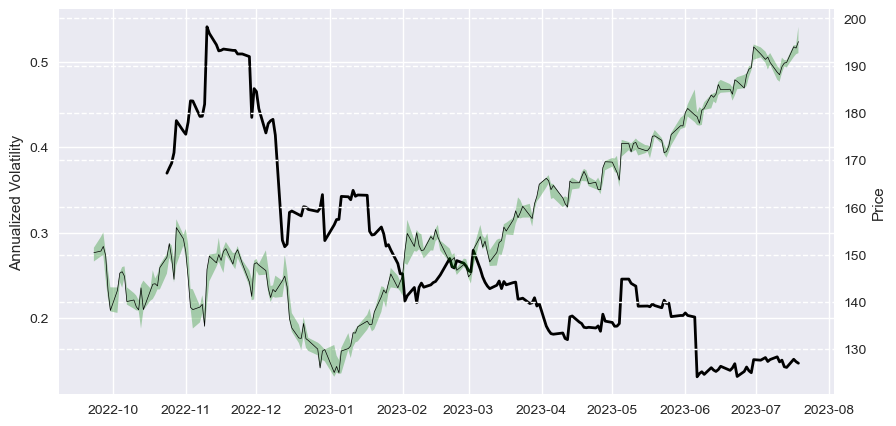

In [315]:
# We now want to get the realised volatility over the last 30 days
data['log_return'] = np.log(data['Close']) - np.log(data['Close'].shift(1))
data['volatility'] = data['log_return'].rolling(21).std() * np.sqrt(252)


fig = plt.figure(figsize=(10, 5))
plt.plot(data['volatility'], color='k', linewidth=2)
plt.ylabel('Annualized Volatility')
# on seperate axis plot the price
ax2 = plt.twinx()
ax2.plot(data['Close'], color='k', linewidth=0.5)
ax2.fill_between(data.index, data['Low'], data['High'], facecolor='g', alpha=0.3)
ax2.set_ylabel('Price')

plt.grid(linestyle='--')
plt.show()

# Get Options data

Here we will be in the business of selling a single option on Apple stock. 

We will use the Black-Scholes formula to calculate the price of the option.  We will then use the delta hedging strategy to hedge the option weekly.  We will then calculate the profit and loss of the option and the hedging strategy.

Recall that a call gives us, the owner the right but not the obligation to purchase the stock at a given price, the strike price, at a given time, the maturity.  The price we pay for this right is the premium.

In [313]:
# get expirey date within tau days of yesterday
tau = 77
tau_trading = 60
dtau = 5
expiry_date = (dt.datetime.today() + dt.timedelta(days=tau)).date()

# load in the options data
options = pd.read_csv('./data/options.csv', index_col=0)


,contractSymbol,currency,lastPrice,change,percentChange,volume,openInterest,bid,ask,contractSize,expiration,lastTradeDate,impliedVolatility,inTheMoney
Strike,,,,,,,,,,,,,,
55.0,AAPL231020C00055000,USD,137.03,0.000000,0.000000,1,3,138.40,140.85,REGULAR,1697760000,1688738105,1.409183,True
60.0,AAPL231020C00060000,USD,133.23,0.000000,0.000000,14,16,134.70,136.30,REGULAR,1697760000,1689606174,1.226566,True
65.0,AAPL231020C00065000,USD,87.00,0.000000,0.000000,1,2,100.85,102.15,REGULAR,1697760000,1678896887,0.000010,True
70.0,AAPL231020C00070000,USD,104.91,0.000000,0.000000,2,160,109.95,111.45,REGULAR,1697760000,1683314370,0.000010,True
75.0,AAPL231020C00075000,USD,115.55,0.000000,0.000000,30,225,120.05,120.60,REGULAR,1697760000,1688057772,0.961914,True
80.0,AAPL231020C00080000,USD,113.75,0.000000,0.000000,2,2,115.40,115.60,REGULAR,1697760000,1688136193,0.945801,True
85.0,AAPL231020C00085000,USD,105.37,0.000000,0.000000,1,9,110.10,110.85,REGULAR,1697760000,1687976334,0.881837,True
90.0,AAPL231020C00090000,USD,101.71,0.000000,0.000000,200,258,105.55,105.80,REGULAR,1697760000,1689364796,0.865968,True
95.0,AAPL231020C00095000,USD,93.69,0.000000,0.000000,1,154,100.30,100.60,REGULAR,1697760000,1687544298,0.769534,True


In [295]:
# get the option that is the closest to the money
idx = np.abs(options.index - S0).argmin()
option = options.iloc[idx]

# We now purchase the option, which controls 100 shares so the price is 
C0 = option['lastPrice']

# get strike price
K = option.name

# we will assume the volatility is the same as the last realised volatility
vol = data['volatility'].values[-1]/(100/55**0.5)


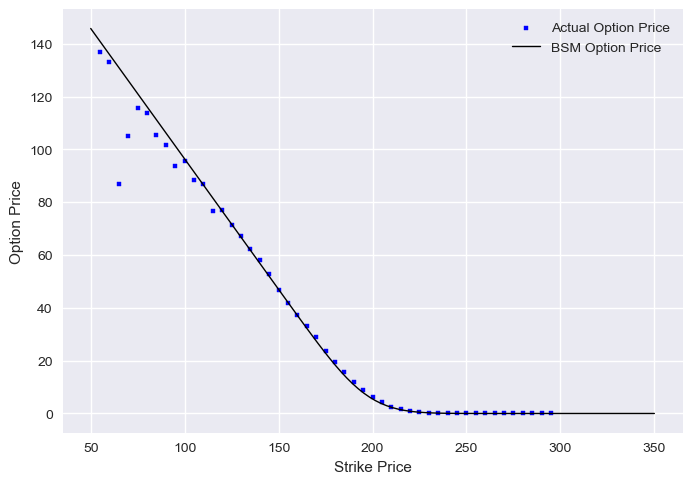

In [296]:
# We will now compare the BSM to the actual options price
K_vals = np.linspace(50, 350, 100)

# Get the call price
call_price = OptionsPriceBSM(S0, K_vals, tau_trading, vol, r, option_type='call')

plt.scatter(options.index, options['lastPrice'], color='b', s=10, marker='s', label='Actual Option Price')
plt.plot(K_vals, call_price, color='k', linewidth=1, label='BSM Option Price')
plt.xlabel('Strike Price')
plt.ylabel('Option Price')
plt.legend()

plt.show()

In [297]:
# Assuming geometric brownian motion, we can simulate the stock price
# over the next 77 days which is 60 trading days
t = np.arange(10e-4, tau_trading+dtau, dtau) 

# number of trajectories
n = 1
# simulate the stock price assuming no drift
St = stockprice_evolution(S0, t, dtau, 0.000, vol, n)

# define a function that returns greeks using black scholes
Ct = OptionsPriceBSM(St, K, t[::-1], vol, r, option_type='call')
deltat = OptionDeltaBSM(St, K, t[::-1], vol, r, option_type='call')
deltat = np.round(100*deltat, 0).astype(int)

# Compute evolution of wealth over time
dr = np.exp(r*dtau)


In [298]:
# We now want to compute our net cash flow at each time step assuming a 100 multiplier 
# We will assume that we have bought the option at the start, so we have a cash outflow

X0 = - 100*C0

# We are long the call, so we need to sell delta shares of the stock
X0

-894.9999999999999

In [299]:
K

195.0

In [300]:
St

array([[195.19000244, 196.29239593, 190.49739634, 193.91429575,
        195.96826328, 190.22552759, 186.22320543, 192.8048676 ,
        193.06693871, 193.45739609, 190.26575239, 187.72312213,
        185.44295804]])

In [301]:
payoff = np.maximum(St.T[-1]-K, 0)
payoff



array([0.])

In [302]:
# create a dataframe to store the data with index name as week 
df = pd.DataFrame(index=np.arange(len(t)), columns=['Stock Price', 'Option Price', 'Delta'])
df.index.name = 'Week'
df['Stock Price'] = St[0]
df['Option Price'] = Ct[0]
df['Delta'] =- deltat[0]
df['Delta Adjustments'] = df['Delta'].diff()
df['Total Delta Adjustment'] = df.loc[0, 'Delta'] - df['Delta']
df['Adjustment Cashflow'] = df['Delta Adjustments']*df['Stock Price']*dr
df['Interest on Cash'] = df['Adjustment Cashflow']*(dr-1)
df['Net Position'] = df['Delta'] * df['Stock Price']  + 100*df.loc[0, 'Option Price'] 

df

,Stock Price,Option Price,Delta,Delta Adjustments,Total Delta Adjustment,Adjustment Cashflow,Interest on Cash,Net Position
Week,,,,,,,,
0,195.190002,7.885709,-58,NaN,0,NaN,NaN,-10532.449202
1,196.292396,8.153845,-60,-2.0,2,-392.980692,-0.396299,-10988.972816
2,190.497396,4.718418,-45,15.0,-13,2860.342536,2.884497,-7783.811896
3,193.914296,5.998698,-53,-8.0,-5,-1552.878781,-1.565992,-9488.886735
4,195.968263,6.724510,-59,-6.0,1,-1176.995319,-1.186935,-10773.556594
5,190.225528,3.428116,-40,19.0,-18,3617.929831,3.648482,-6820.450164
6,186.223205,1.709769,-26,14.0,-32,2609.754017,2.631792,-4053.232402
7,192.804868,3.632035,-47,-21.0,-11,-4052.985313,-4.087211,-8273.257838
8,193.066939,3.225122,-46,1.0,-12,193.261636,0.194894,-8092.508241


In [180]:
OrigPNL = 100*(X0 - np.maximum(St[0,-1]-K,0))
carry_int_options = (np.exp(r*tau_trading) - 1)*C0*100

df['Adjustment Cashflow'].sum()


8866.141091686884

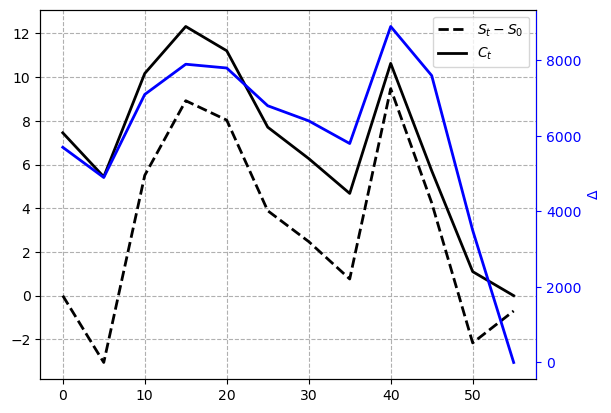

In [28]:
ix = 0
plt.plot(t, (St- S0)[ix], color='k', linewidth=2, linestyle='--', label=r'$S_{t} - S_{0}$')
plt.plot(t, Ct[ix], color='k', linewidth=2, label=r'$C_{t}$')

plt.legend()
plt.grid(linestyle='--')

ax2 = plt.twinx()
ax2.plot(t, 100*deltat[ix], color='b', linewidth=2)
ax2.set_ylabel(r'$\Delta$', color='b')
ax2.spines['right'].set_color('b')
ax2.tick_params(axis='y', colors='b')
# ax2.set_ylim(0, 1)


plt.show()

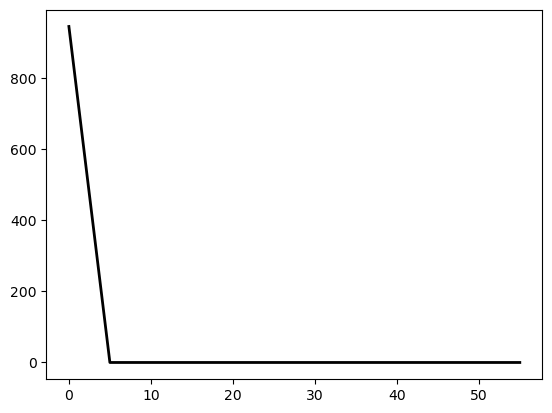

In [29]:
plt.plot(t, Xt[ix], color='k', linewidth=2, label=r'$X_{t}$')

plt.show()